In [1]:
from pipe import take

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import lightning as pl

from torch.utils.data import DataLoader, TensorDataset

import wandb

from data import generate_trajectories

In [2]:
# mpl configuration
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [3]:
# reproducability
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# names of the phase vector components
phase_names = (r"$\phi$", r"$\omega$")

## По заданной $g(t)$ восстановим наблюдения

In [5]:
a = 0.15    # Сильная кубическая нелинейность
b = -1.2    # Резкий "горб" в середине интервала
c = 2.0     # Быстрый линейный рост
d = 3.0     # Низкое стартовое значение (увеличивает чувствительность)
g = lambda t: a * t**3 + b * t**2 + c * t + d

L = 0.5

In [6]:
num_simple_trajectories = 20
phi0 = 2. * torch.rand((num_simple_trajectories, 1)) - 1.
omega0 = 2. * torch.rand((num_simple_trajectories, 1)) - 1.
z0_simple = torch.concat([phi0, omega0], dim=1)

num_hard_1_trajectories = 20
phi0 = 3. * torch.ones((num_hard_1_trajectories, 1)) + torch.randn((num_hard_1_trajectories, 1))
omega0 = torch.zeros((num_hard_1_trajectories, 1))
z0_hard_1 = torch.concat([phi0, omega0], dim=1)

num_hard_2_trajectories = 20
omega0 = 5. * torch.ones((num_hard_2_trajectories, 1)) + torch.randn((num_hard_2_trajectories, 1))
phi0 = torch.zeros((num_hard_1_trajectories, 1))
z0_hard_2 = torch.concat([phi0, omega0], dim=1)

z0 = [z0_simple, z0_hard_1, z0_hard_2]

In [7]:
t_span = [0, 6]
num_samples = 100
t = torch.linspace(*t_span, num_samples)

sigma = torch.tensor([1e-1, 1e-1])

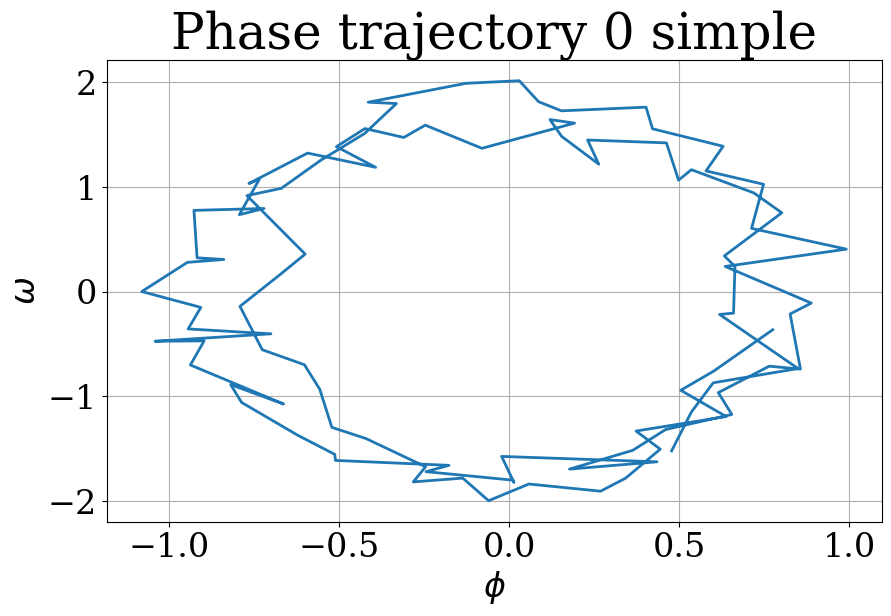

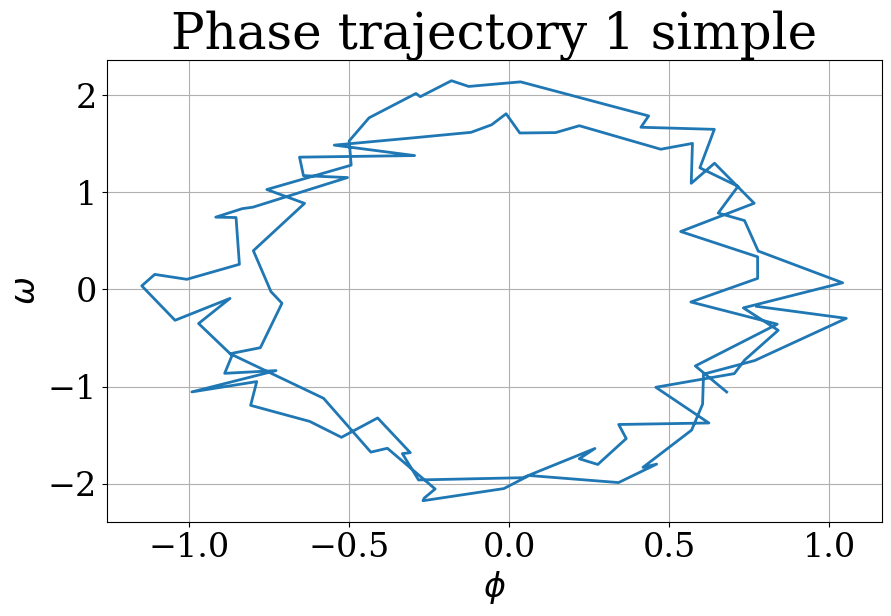

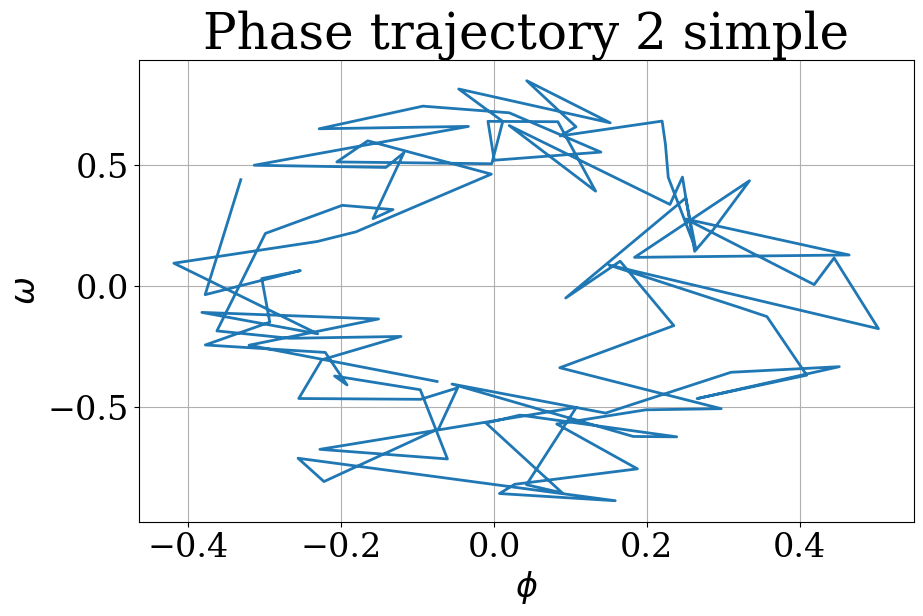

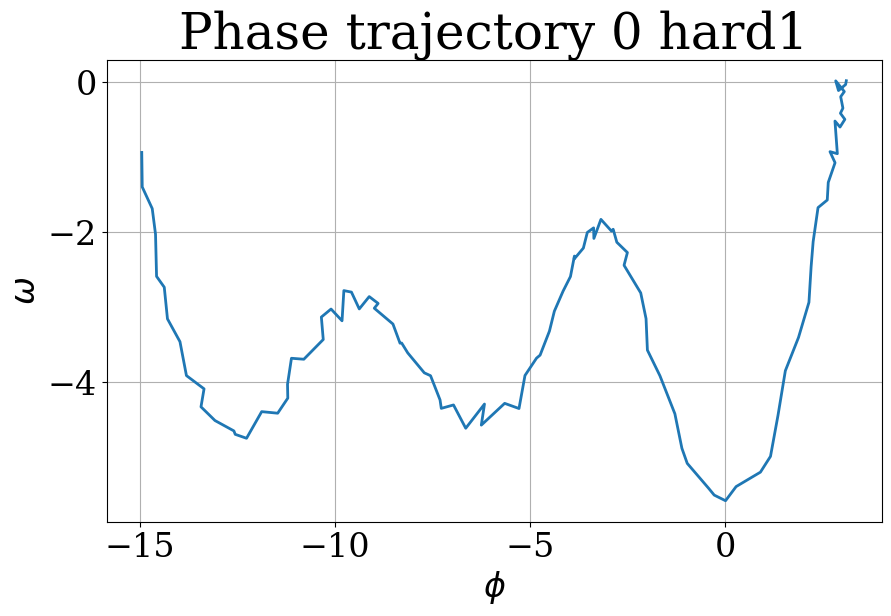

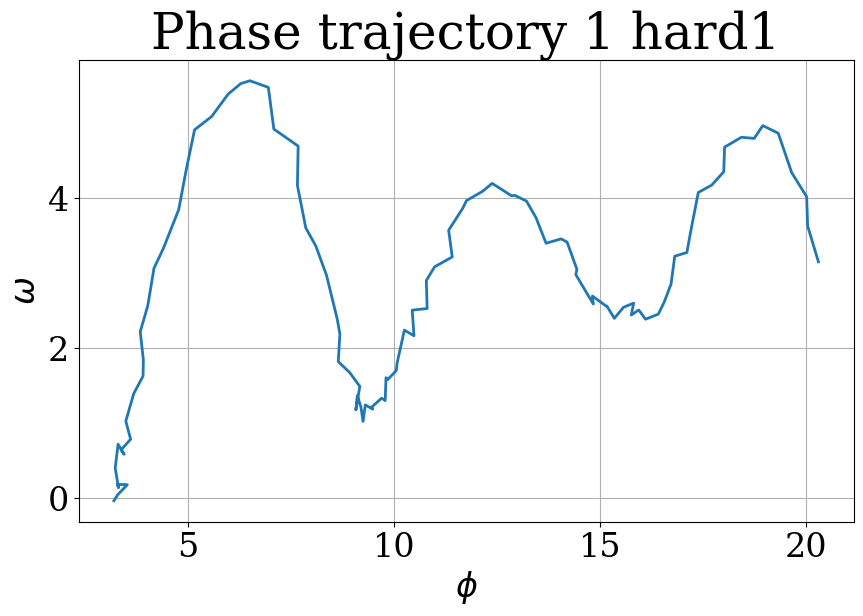

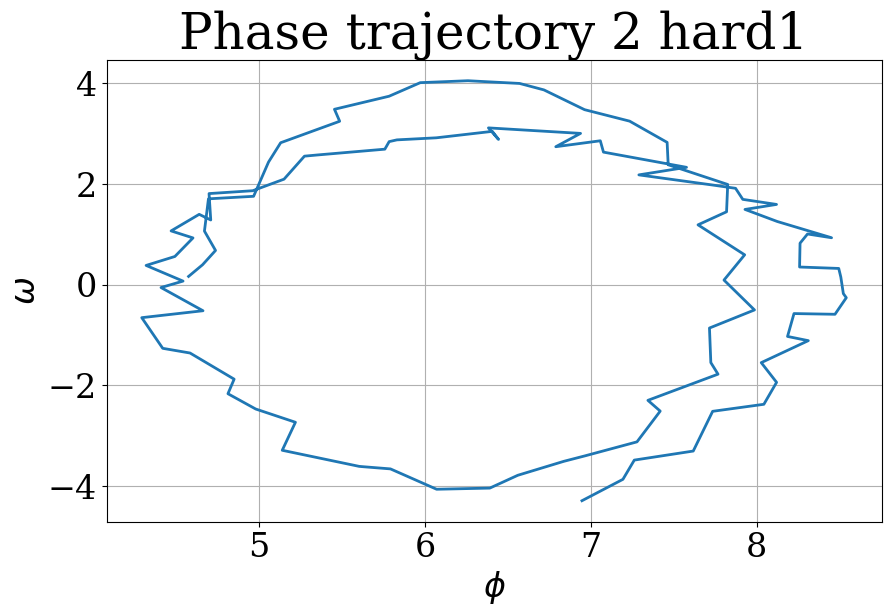

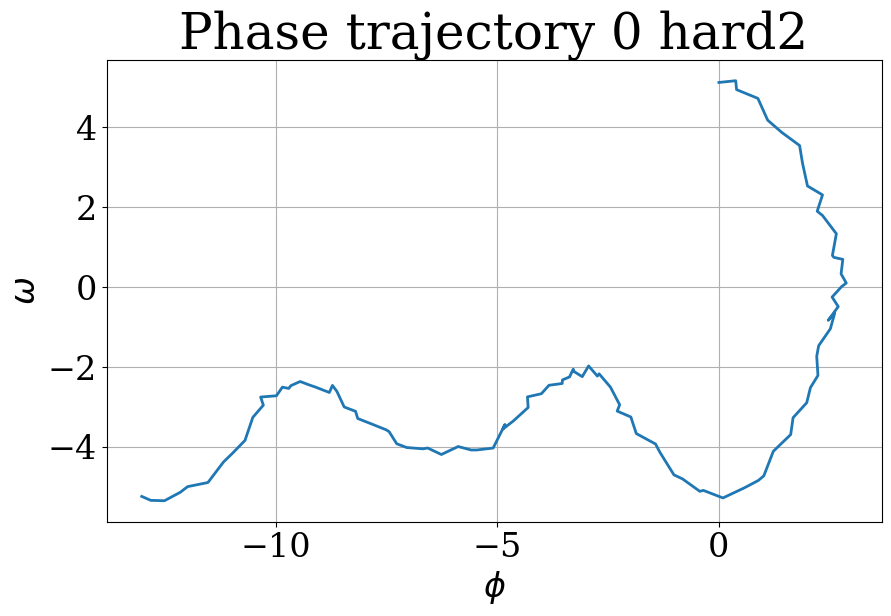

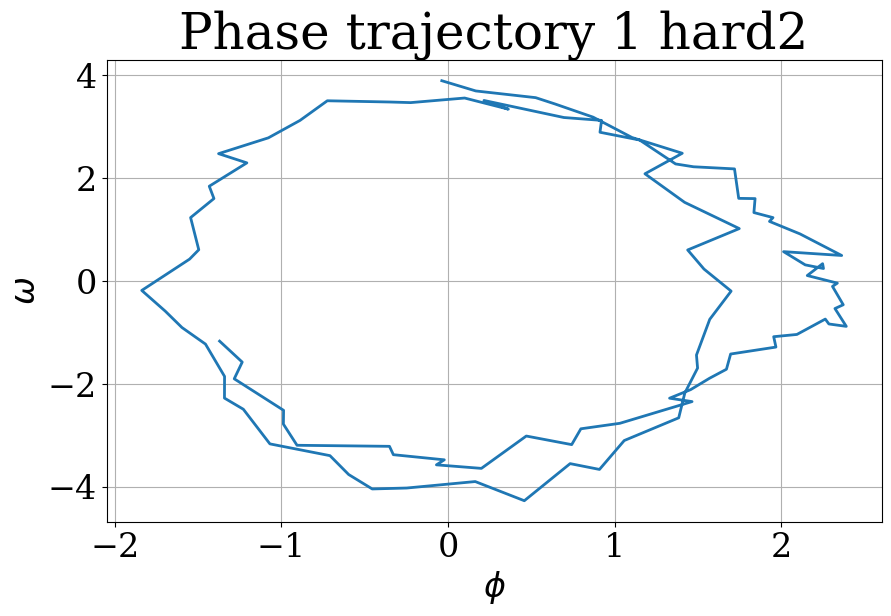

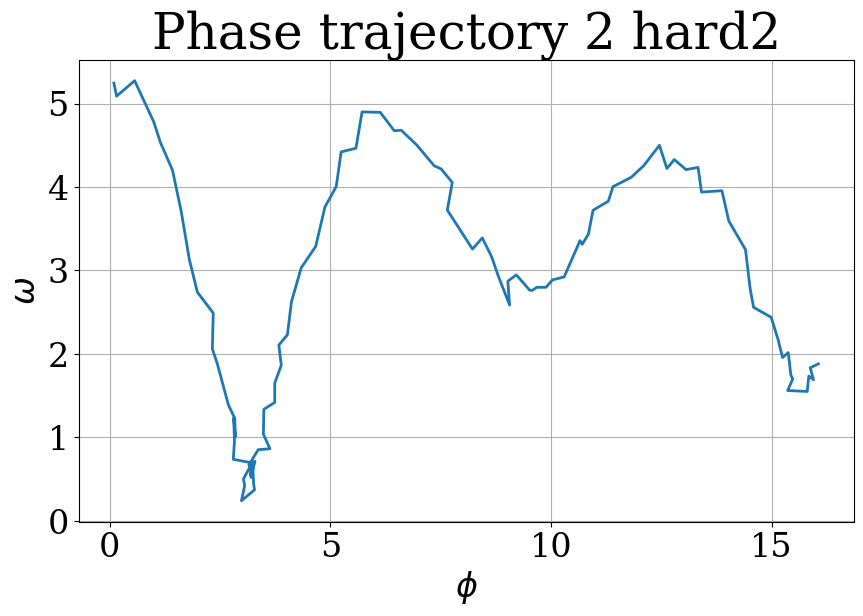

In [8]:
for z0_cur, traj_name in zip(z0, ["simple", "hard1", "hard2"]):
    trajectories = generate_trajectories(g, L, z0_cur, sigma, t)[:3]

    for i in range(trajectories.shape[0]):
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(trajectories[i, :, 0].numpy(), trajectories[i, :, 1].numpy())

        ax.grid(True)
        ax.set_title(f"Phase trajectory {i} {traj_name}")
        ax.set_xlabel(phase_names[0])
        ax.set_ylabel(phase_names[1]);

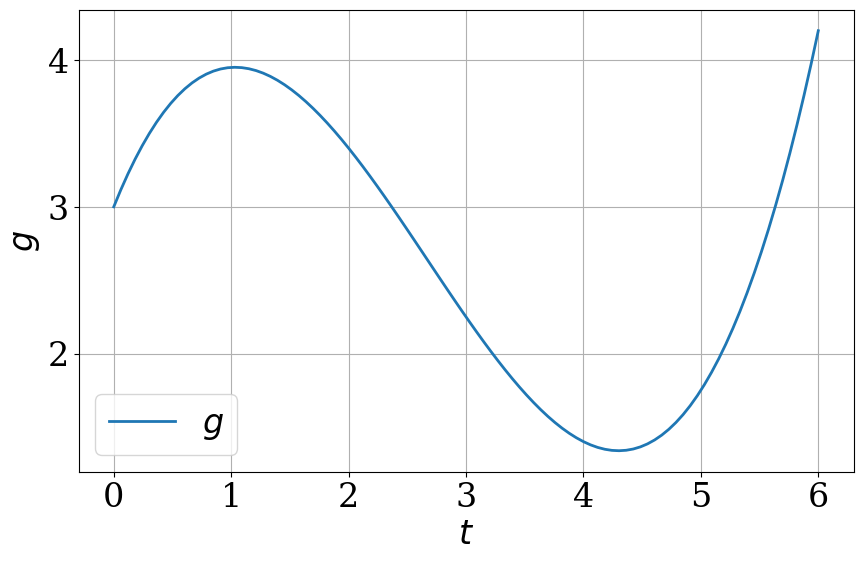

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t.numpy(), g(t).numpy(), label="$g$")

ax.legend()
ax.grid(True)
ax.set_ylabel("$g$")
ax.set_xlabel("$t$");

In [10]:
z0 = torch.concat(z0)
trajectories = generate_trajectories(g, L, z0, sigma, t)
num_trajectories = trajectories.shape[0]
trajectories.shape

torch.Size([60, 100, 2])

## Восстановим $g(t)$ по наблюдениям

Make dataset and dataloaders from generated trajectories

In [11]:
# add g to inital conditions and trajectories
g0 = g(torch.tensor([0.]))[None].expand(num_trajectories, 1)
x0 = torch.concat([z0, g0], dim=1)

g_traj = g(t)

x = torch.concat(
    [trajectories, g_traj[None,:, None].expand(num_trajectories, -1, -1)],
    dim=2
)

dataset = TensorDataset(x0, x)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

In [12]:
# approximation for the g field
class GPolyPrime(nn.Module):
    def __init__(self, order = 5):
        super().__init__()
        self.order = order
        self.poly_coef = nn.Parameter(torch.arange(0, -order - 1, -1).exp())

    def forward(self, t, g):
        # g arg is dummy, but contains batch dim
        t_feat = torch.tensor([t ** i for i in range(self.order + 1)]).to(t.device)
        return self.poly_coef.dot(t_feat).expand_as(g)

In [13]:
from vf import ODELightningModule, PendulumNodeVf

from lightning.pytorch.loggers import WandbLogger, TensorBoardLogger


# build vector fields and lightning module
g_prime_poly = GPolyPrime(order=5)
full_vf = PendulumNodeVf(g_prime_poly, L)
model = ODELightningModule(full_vf, t, g_traj, lr=1e-4)

# logger = WandbLogger(project="pendulum_ode")
logger = TensorBoardLogger("logs")

trainer = pl.Trainer(max_epochs=30, enable_progress_bar=True, logger=logger, log_every_n_steps=5)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kirill/.cache/pypoetry/virtualenvs/2025-project-186-VoyVcILs-py3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | vf        | PendulumNodeVf | 6      | train
1 | criterion | MSELoss        | 0      | train
-----------------------------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/kirill/.cache/pypoetry/virtualenvs/2025-project-186-VoyVcILs-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [15]:
g_prime_poly.poly_coef

Parameter containing:
tensor([ 0.9974,  0.3638,  0.1299,  0.0422,  0.0076, -0.0077],
       requires_grad=True)

In [16]:
a = 0.15    # Сильная кубическая нелинейность
b = -1.2    # Резкий "горб" в середине интервала
c = 2.0     # Быстрый линейный рост
d = 3.0     # Низкое стартовое значение (увеличивает чувствительность)

Draw predicted trajectories

In [17]:
# predict for first 3 inital conditions
with torch.no_grad():
    pred = model(x0[:3], t)
    pred.shape

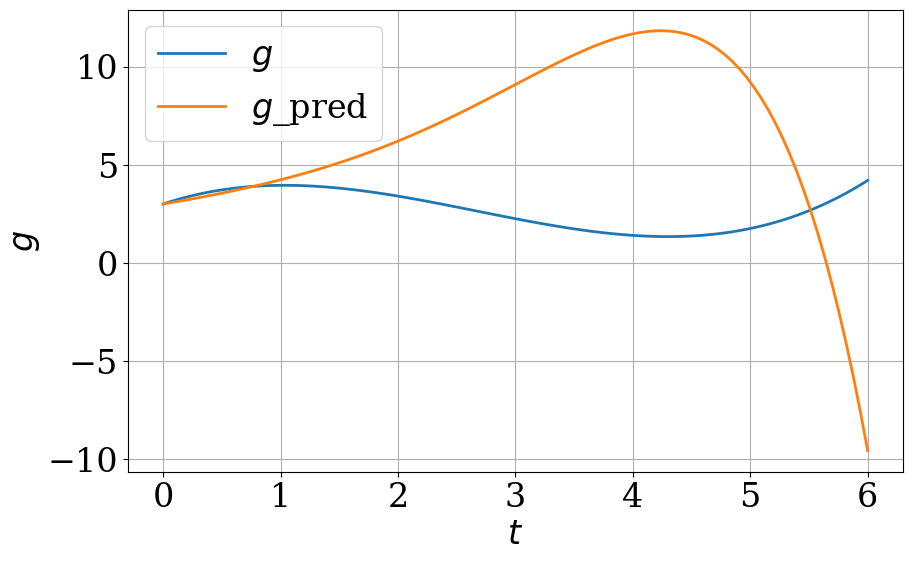

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t.numpy(), g(t).numpy(), label="$g$")
ax.plot(t.numpy(), pred[0, :, 2].numpy(), label="$g$_pred")

ax.legend()
ax.grid(True)
ax.set_ylabel("$g$")
ax.set_xlabel("$t$");

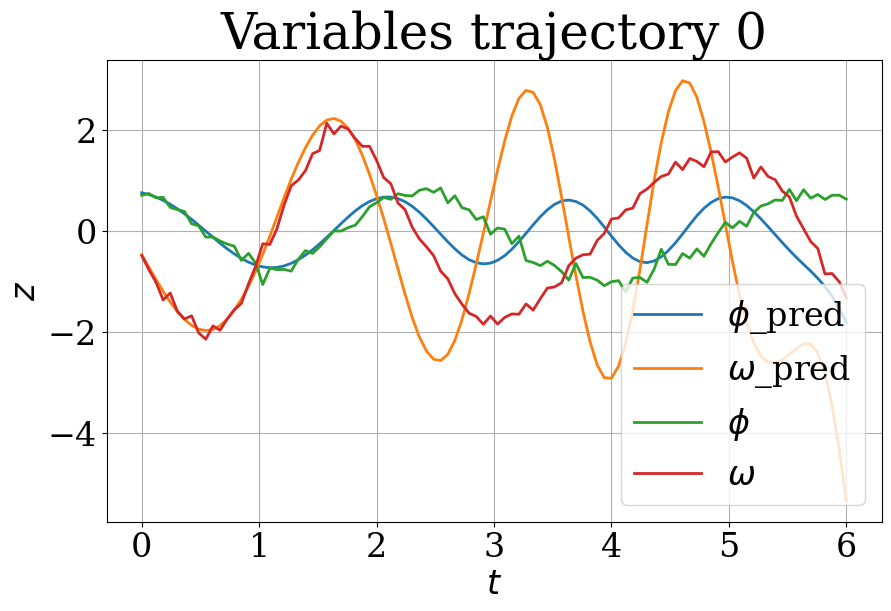

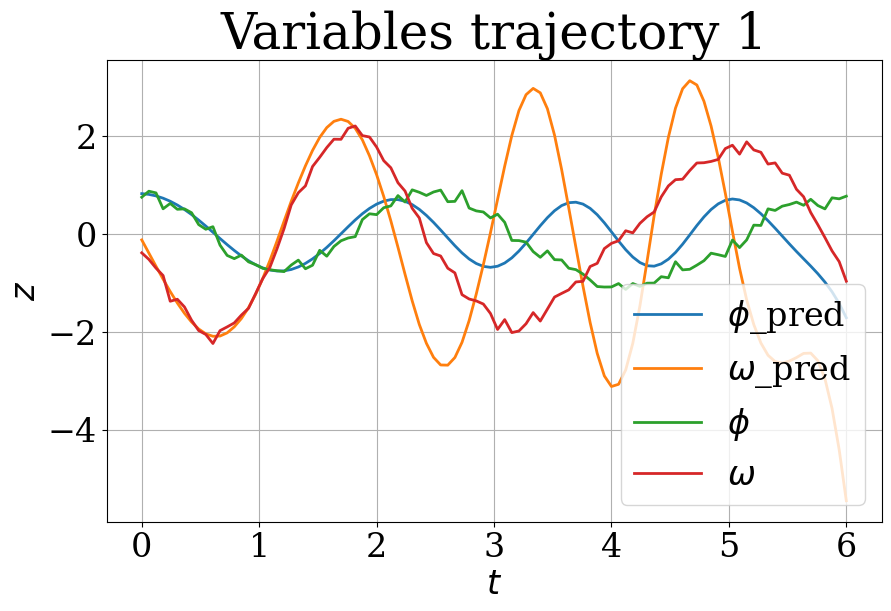

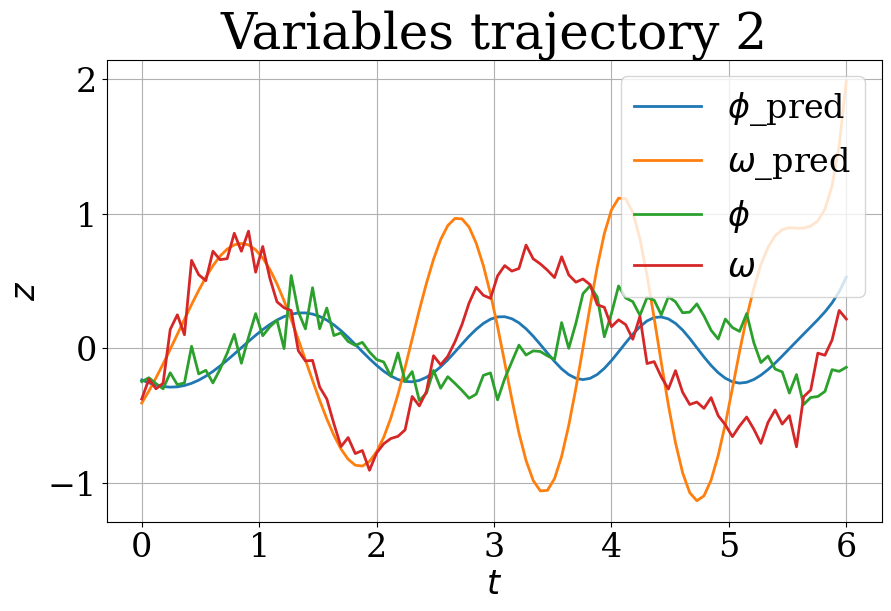

In [19]:
for i in range(num_trajectories) | take(3):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(t.numpy(), pred[i, :, 0].numpy(), label=phase_names[0] + "_pred")
    ax.plot(t.numpy(), pred[i, :, 1].numpy(), label=phase_names[1] + "_pred")

    ax.plot(t.numpy(), trajectories[i, :, 0].numpy(), label=phase_names[0])
    ax.plot(t.numpy(), trajectories[i, :, 1].numpy(), label=phase_names[1])

    ax.legend()
    ax.grid(True)
    ax.set_title(f"Variables trajectory {i}")
    ax.set_ylabel("$z$")
    ax.set_xlabel("$t$");

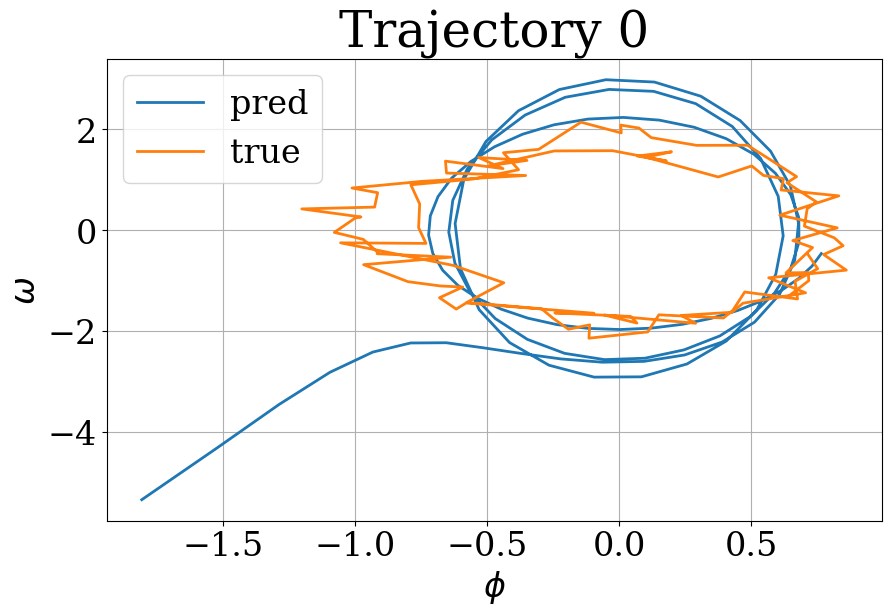

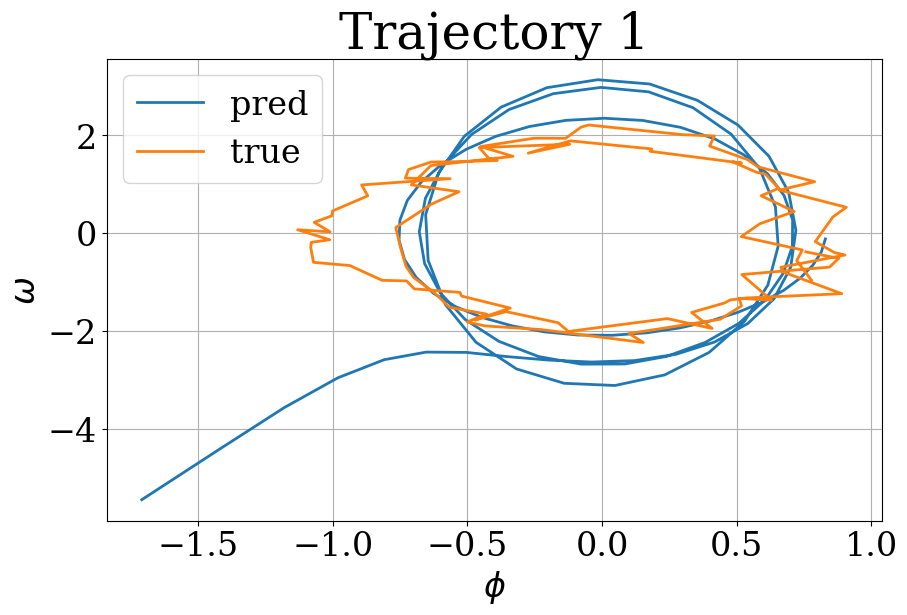

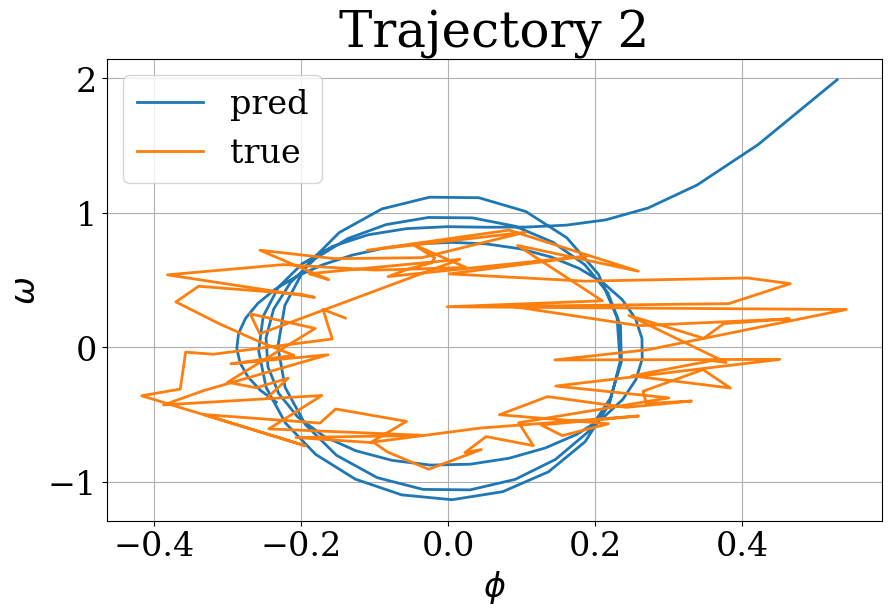

In [20]:
for i in range(num_trajectories) | take(3):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(pred[i, :, 0].numpy(), pred[i, :, 1].numpy(), label="pred")
    ax.plot(trajectories[i, :, 0].numpy(), trajectories[i, :, 1].numpy(), label="true")

    ax.legend()
    ax.grid(True)
    ax.set_title(f"Trajectory {i}")
    ax.set_ylabel(r"$\omega$")
    ax.set_xlabel(r"$\phi$");